100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.59MB/s]


Epoch 1 Loss: 163.8715
Epoch 2 Loss: 120.0594
Epoch 3 Loss: 112.6632
Epoch 4 Loss: 109.2833
Epoch 5 Loss: 107.1845
Epoch 6 Loss: 105.7193
Epoch 7 Loss: 104.6782
Epoch 8 Loss: 103.8007
Epoch 9 Loss: 103.1704
Epoch 10 Loss: 102.6101


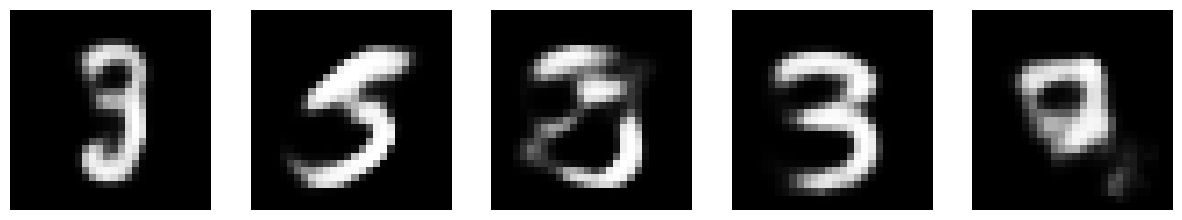

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- CONFIG ---
batch_size = 128
latent_dim = 20
epochs = 10  # Increase if you want better generation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DATA ---
transform = transforms.ToTensor()
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)

# --- MODEL ---
class CVAE(nn.Module):
    def __init__(self, latent_dim=latent_dim):
        super(CVAE, self).__init__()
        self.fc1 = nn.Linear(28*28 + 10, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)
        self.fc3 = nn.Linear(latent_dim + 10, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x, y):
        h1 = torch.relu(self.fc1(torch.cat([x, y], 1)))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        h3 = torch.relu(self.fc3(torch.cat([z, y], 1)))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

model = CVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- LOSS ---
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# --- TRAIN ---
for epoch in range(1, epochs+1):
    model.train()
    train_loss = 0
    for data, target in train_loader:
        data = data.view(-1, 28*28).to(device)
        target_onehot = torch.eye(10)[target].to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, target_onehot)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f"Epoch {epoch} Loss: {train_loss / len(train_loader.dataset):.4f}")

# --- SAVE MODEL ---
torch.save(model.state_dict(), "cvae_mnist.pth")

# --- SAMPLE GENERATION ---
def generate_digit(model, digit, num_samples=5, latent_dim=latent_dim):
    model.eval()
    y = torch.eye(10)[digit].repeat(num_samples, 1).to(device)
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        samples = model.decode(z, y).cpu().numpy()
    return samples.reshape(num_samples, 28, 28)

# Preview sample output
digit = 3
samples = generate_digit(model, digit)
fig, axs = plt.subplots(1, 5, figsize=(15,3))
for i in range(5):
    axs[i].imshow(samples[i], cmap='gray')
    axs[i].axis('off')
plt.show()